# Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn.preprocessing as preprocessing
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import time
import datetime
import sys
import os

sys.path.append(os.path.abspath(os.path.join("../")))

from src.evaluate import ams_score

# Import data

In [2]:
data_path = "../data/raw/higgs-challenge.csv.gz"
data = pd.read_csv(data_path, compression="gzip")
data.drop(columns=["KaggleSet", "KaggleWeight"], inplace=True)  # These two columns are just for the competition
# set EventId as index
data.set_index("EventId", inplace=True)

## Inspect data for missing values

In [3]:
# A value is missing if it is equal to -999.0
data.replace(-999.0, np.nan, inplace=True)
# Check for missing values by raising a warning if any are found
if data.isnull().sum().any():
    print("Warning: Missing values found!")
else:
    print("No missing values found.")

In [4]:
# Count number of missing values per column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100
# Print columns with missing values and their percentages
for col, perc in missing_values_percentage.items():
    if perc > 0:
        print(f"Column: {col}, Missing Values: {perc:.2f}%")

Column: DER_mass_MMC, Missing Values: 15.23%
Column: DER_deltaeta_jet_jet, Missing Values: 70.91%
Column: DER_mass_jet_jet, Missing Values: 70.91%
Column: DER_prodeta_jet_jet, Missing Values: 70.91%
Column: DER_lep_eta_centrality, Missing Values: 70.91%
Column: PRI_jet_leading_pt, Missing Values: 40.01%
Column: PRI_jet_leading_eta, Missing Values: 40.01%
Column: PRI_jet_leading_phi, Missing Values: 40.01%
Column: PRI_jet_subleading_pt, Missing Values: 70.91%
Column: PRI_jet_subleading_eta, Missing Values: 70.91%
Column: PRI_jet_subleading_phi, Missing Values: 70.91%


# Visualize data distributions

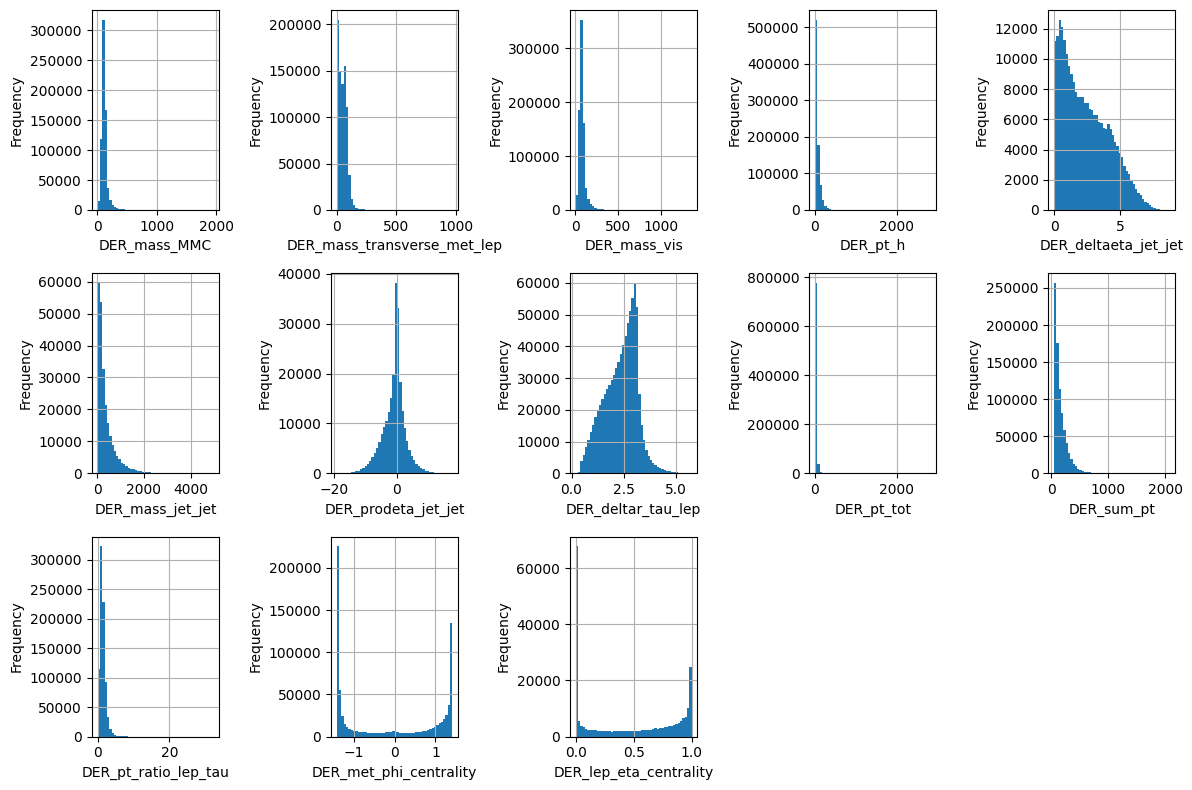

In [5]:
# Plot distributions of each column in data in one figure
der_columns = data.columns[np.strings.startswith(np.array(data.columns, dtype=str), "DER_")]
plt.figure(figsize=(12, 8))
for i, column in enumerate(der_columns):
    plt.subplot(3, 5, i + 1)
    data[column].hist(bins=50)
    # plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

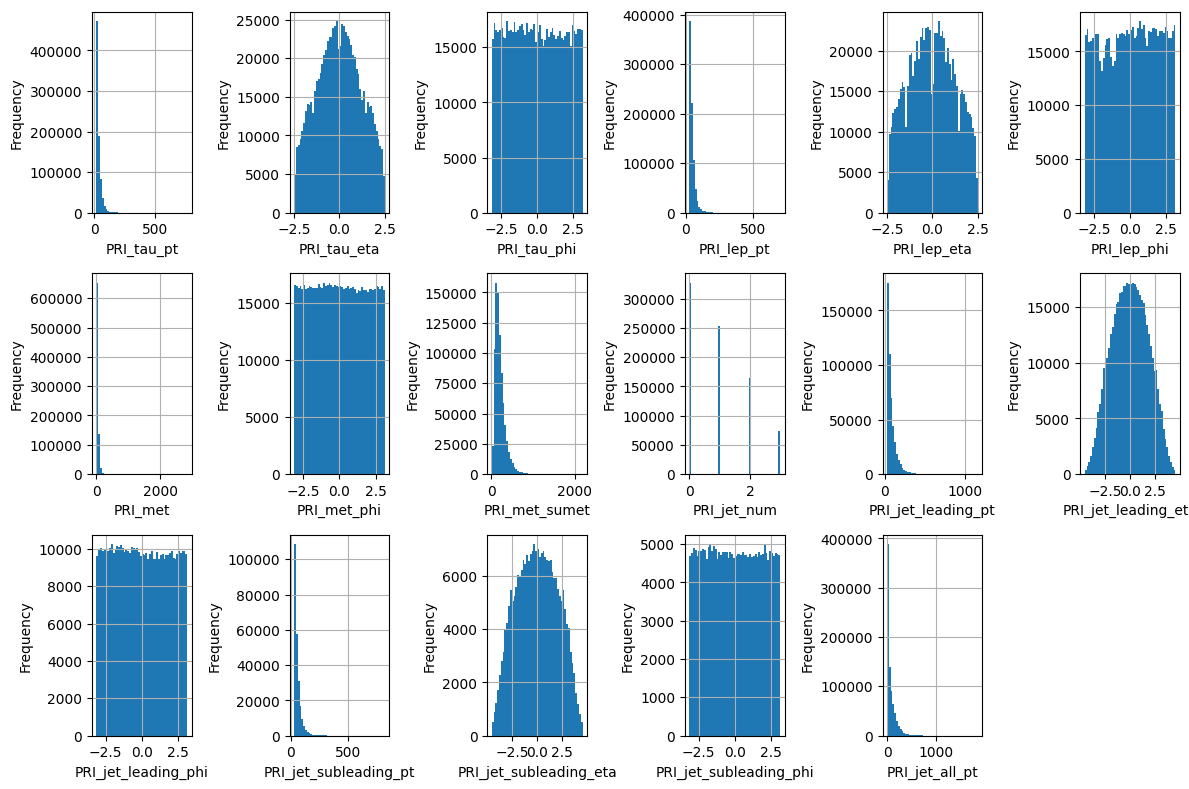

In [6]:
# Plot distributions of each column in data in one figure
pri_columns = data.columns[np.strings.startswith(np.array(data.columns, dtype=str), "PRI_")]
plt.figure(figsize=(12, 8))
for i, column in enumerate(pri_columns):
    plt.subplot(3, 6, i + 1)
    data[column].hist(bins=50)
    # plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

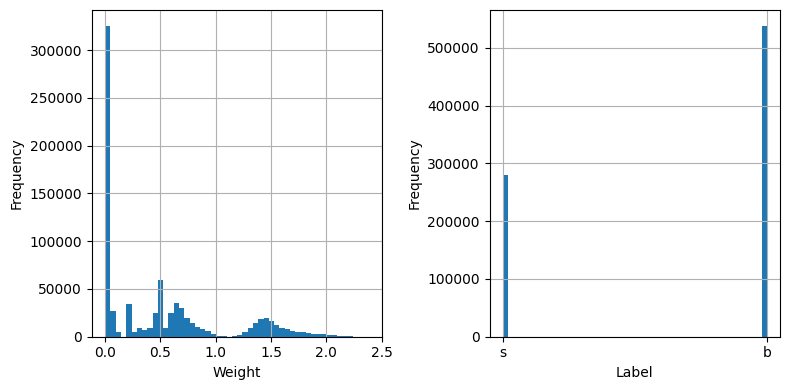

In [7]:
# Plot distributions of each column in data in one figure
other_columns = data.columns[
    ~np.strings.startswith(np.array(data.columns, dtype=str), "PRI_")
    & ~np.strings.startswith(np.array(data.columns, dtype=str), "DER_")
]
plt.figure(figsize=(8, 4))
for i, column in enumerate(other_columns):
    plt.subplot(1, 2, i + 1)
    data[column].hist(bins=50)
    # plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Split data into training and test sets

In [8]:
# Drop rows with any missing values
data_clean = data.dropna()
data_train, data_test = train_test_split(data_clean, test_size=0.2, random_state=42)
weights_train = data_train["Weight"]
weights_test = data_test["Weight"]
X_train = data_train.drop(["Weight", "Label"], axis=1)
X_test = data_test.drop(["Weight", "Label"], axis=1)
y_train = data_train["Label"]
y_test = data_test["Label"]

# Basic Logistic regression model

In [9]:
# Train a logistic regression model on the training set and evaluate on the test set
model = LogisticRegression(max_iter=10000)  # We need more iterations to converge
time_start = time.monotonic()
model.fit(X_train, y_train)
train_end = time.monotonic()
print(f"Training time: {str(datetime.timedelta(seconds=train_end - time_start))}")

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]
test_end = time.monotonic()
print(f"Inference time: {str(datetime.timedelta(seconds=test_end - train_end))}")


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Training time: 0:00:14.767589
Inference time: 0:00:00.007055
Accuracy: 0.727720004472772
Classification Report:
               precision    recall  f1-score   support

           b       0.73      0.77      0.75     23658
           s       0.72      0.68      0.70     21057

    accuracy                           0.73     44715
   macro avg       0.73      0.73      0.73     44715
weighted avg       0.73      0.73      0.73     44715



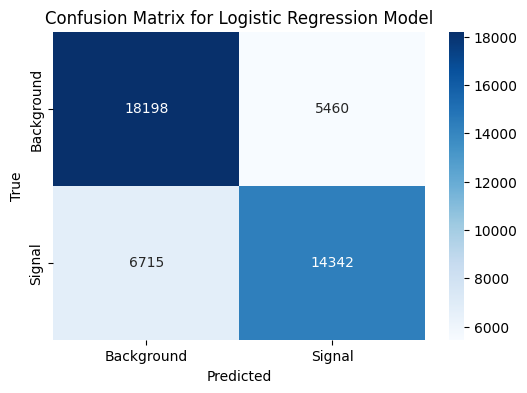

In [10]:
# Make confusion matrix
cm = confusion_matrix(y_test, y_pred)
true_positives = cm[1, 1]
false_positives = cm[0, 1]
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

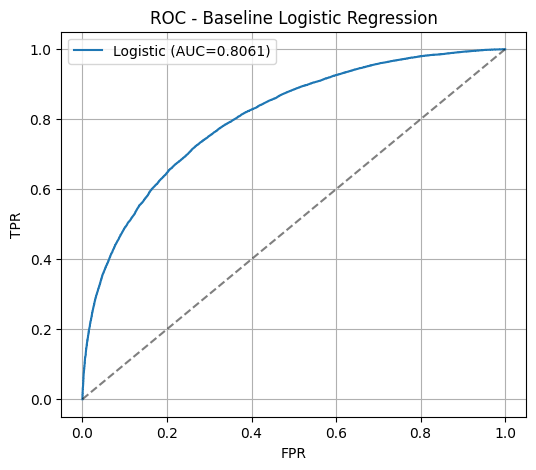

In [11]:
# ROC curve plot for baseline
fpr, tpr, _ = roc_curve(y_test, y_probs, pos_label="s")
auc = roc_auc_score(y_test, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic (AUC={auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Baseline Logistic Regression")
plt.legend()
plt.grid(True)

In [12]:
ams = ams_score(y_test, y_pred, weights_test)
print("AMS Score:", ams)

AMS Score: 0.40494048836909


## With scaling

In [13]:
# Train a logistic regression model on the training set and evaluate on the test set (Scaled data)

time_start = time.monotonic()
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
time_scaled = time.monotonic()
print(f"Scaling time: {str(datetime.timedelta(seconds=time_scaled - time_start))}")

model_scaled = LogisticRegression()
model_scaled.fit(X_train_scaled, y_train)
train_end = time.monotonic()
print(f"Training time: {str(datetime.timedelta(seconds=train_end - time_scaled))}")

y_pred_scaled = model_scaled.predict(X_test_scaled)
y_probs_scaled = model_scaled.predict_proba(X_test_scaled)[:, 1]
test_end = time.monotonic()
print(f"Inference time: {str(datetime.timedelta(seconds=test_end - train_end))}")

print("Accuracy of clean model:", accuracy_score(y_test, y_pred_scaled))
print("Classification Report:\n", classification_report(y_test, y_pred_scaled))

Scaling time: 0:00:00.043536
Training time: 0:00:00.224601
Inference time: 0:00:00.002799
Accuracy of clean model: 0.7279883707927989
Classification Report:
               precision    recall  f1-score   support

           b       0.73      0.77      0.75     23658
           s       0.72      0.68      0.70     21057

    accuracy                           0.73     44715
   macro avg       0.73      0.73      0.73     44715
weighted avg       0.73      0.73      0.73     44715



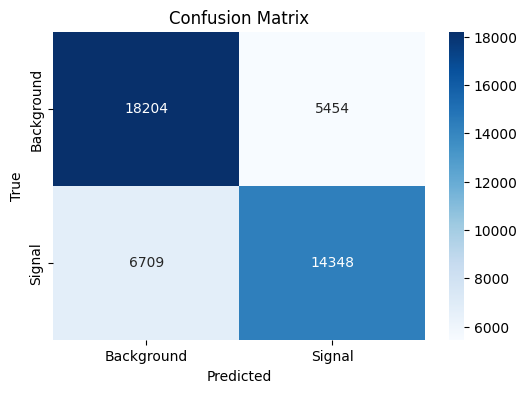

In [14]:
# Make confusion matrix
cm = confusion_matrix(y_test, y_pred_scaled)
true_positives = cm[1, 1]
false_positives = cm[0, 1]
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

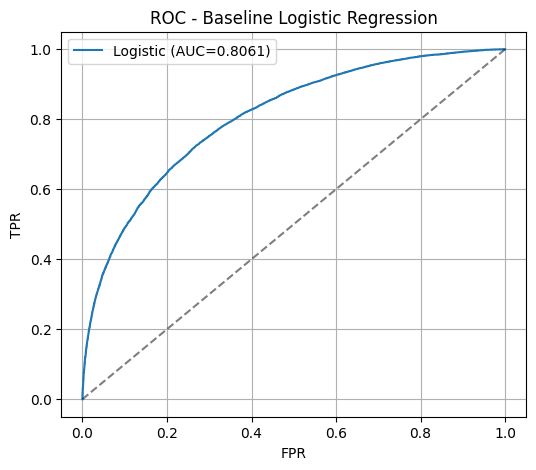

In [15]:
# ROC curve plot for baseline
fpr, tpr, _ = roc_curve(y_test, y_probs_scaled, pos_label="s")
auc = roc_auc_score(y_test, y_probs_scaled)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic (AUC={auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Baseline Logistic Regression")
plt.legend()
plt.grid(True)

In [16]:
ams = ams_score(y_test, y_pred_scaled, weights_test)
print("AMS Score:", ams)

AMS Score: 0.4055209464422945
